In [2]:
import pandas as pd
import numpy as np

In [3]:
# load data
# computational bg from mp
df_mp = pd.read_csv('selected_data.csv')

# experimental bg from matbench
df_matbench = pd.read_json('matbench_expt_gap.json', orient='index').T
# Expand the "data" column into two separate columns
df_matbench[["formula", "bg_expt"]] = pd.DataFrame(df_matbench["data"].tolist(), index=df_matbench.index)

# Drop unnecessary columns, including the "category" column
df_matbench = df_matbench.drop(columns=["data", "index", "columns"])


# experimental bg from ds2
# Reload JSON file
df_ds2 = pd.read_json("data/ds2.json", orient="index")

# Reset index to move 'mpids' into a separate column
df_ds2 = df_ds2.reset_index()


# Rename the columns for clarity
df_ds2.columns = ["mpids", "formula", "bg_mp", "bg"]

# Assuming df_mp has been loaded, we need to merge df_ds2 with df_mp to get the formula
df_ds2 = df_ds2.merge(df_mp[["mpids"]], on="mpids", how="left")


# load data from bandgapdatabase1
df_bandgap = pd.read_csv('bandgap_data_median.csv')

In [4]:

# Ensure df_mp is sorted so that the lowest 'formation_energy_per_atom' is selected
df_mp_sorted = df_mp.sort_values(by="formation_energy_per_atom")

# Drop duplicates based on 'formula', keeping the one with lowest 'formation_energy_per_atom'
df_mp_filtered = df_mp_sorted.drop_duplicates(subset="formula", keep="first")

# Merge df_cleaned with the filtered df_mp to retain only the lowest formation energy per formula
df_merged = df_matbench.merge(df_mp_filtered, on="formula", how="left")
df_filtered = df_merged.dropna(subset=['mpids'])

# filter ds2
df_ds2 = df_ds2[df_ds2["mpids"].isin(df_mp["mpids"])]


In [5]:
# Filter each dataframe to keep only samples with band gap in the range 0.5 to 5
# df_filtered: data from matbench
# df_bandgap: data from bandgapdatabase1
# df_ds2: data from ds2

df_filtered = df_filtered[(df_filtered["bg_expt"] >= 0.5) & (df_filtered["bg_expt"] <= 5)]
df_bandgap = df_bandgap[(df_bandgap["Value"] >= 0.5) & (df_bandgap["Value"] <= 5)]
df_ds2 = df_ds2[(df_ds2["bg"] >= 0.5) & (df_ds2["bg"] <= 5)]


In [6]:
# Convert mpids columns to sets for easy comparison
mpids_filtered = set(df_filtered["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Compute overlaps
overlap_filtered_bandgap = len(mpids_filtered & mpids_bandgap)
overlap_filtered_ds2 = len(mpids_filtered & mpids_ds2)
overlap_bandgap_ds2 = len(mpids_bandgap & mpids_ds2)

# Display results
overlap_summary = pd.DataFrame({
    ("Dataset 1", "Dataset 2"): [
        ("df_filtered", "df_bandgap"),
        ("df_filtered", "df_ds2"),
        ("df_bandgap", "df_ds2"),
    ],
    "Number of Overlaps": [
        overlap_filtered_bandgap,
        overlap_filtered_ds2,
        overlap_bandgap_ds2,
    ]
})

overlap_summary

,"(Dataset 1, Dataset 2)",Number of Overlaps
0,"(df_filtered, df_bandgap)",392
1,"(df_filtered, df_ds2)",149
2,"(df_bandgap, df_ds2)",166


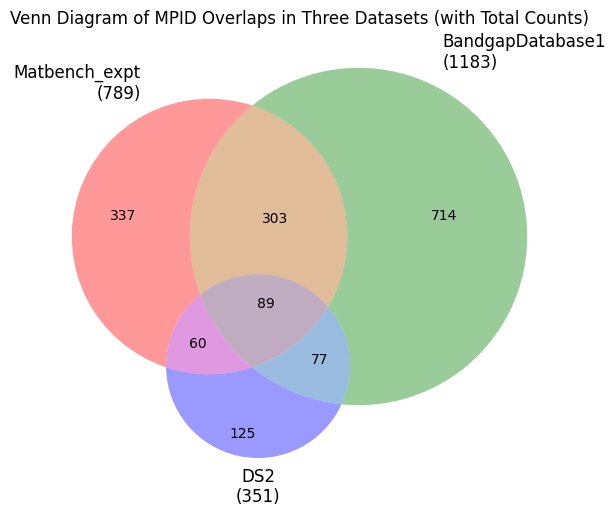

In [7]:
# Re-import necessary libraries since execution state was reset
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Assuming df_filtered, df_bandgap, and df_ds2 have been reloaded

# Convert mpids columns to sets for easy comparison
mpids_filtered = set(df_filtered["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Get total counts for each dataset
count_filtered = len(mpids_filtered)
count_bandgap = len(mpids_bandgap)
count_ds2 = len(mpids_ds2)

# Create a Venn diagram
plt.figure(figsize=(8, 6))
venn = venn3([mpids_filtered, mpids_bandgap, mpids_ds2], 
             set_labels=(f"Matbench_expt\n({count_filtered})", 
                         f"BandgapDatabase1\n({count_bandgap})", 
                         f"DS2\n({count_ds2})"))

plt.title("Venn Diagram of MPID Overlaps in Three Datasets (with Total Counts)")
# save the figure
plt.savefig('venn_diagram.png')
plt.show()



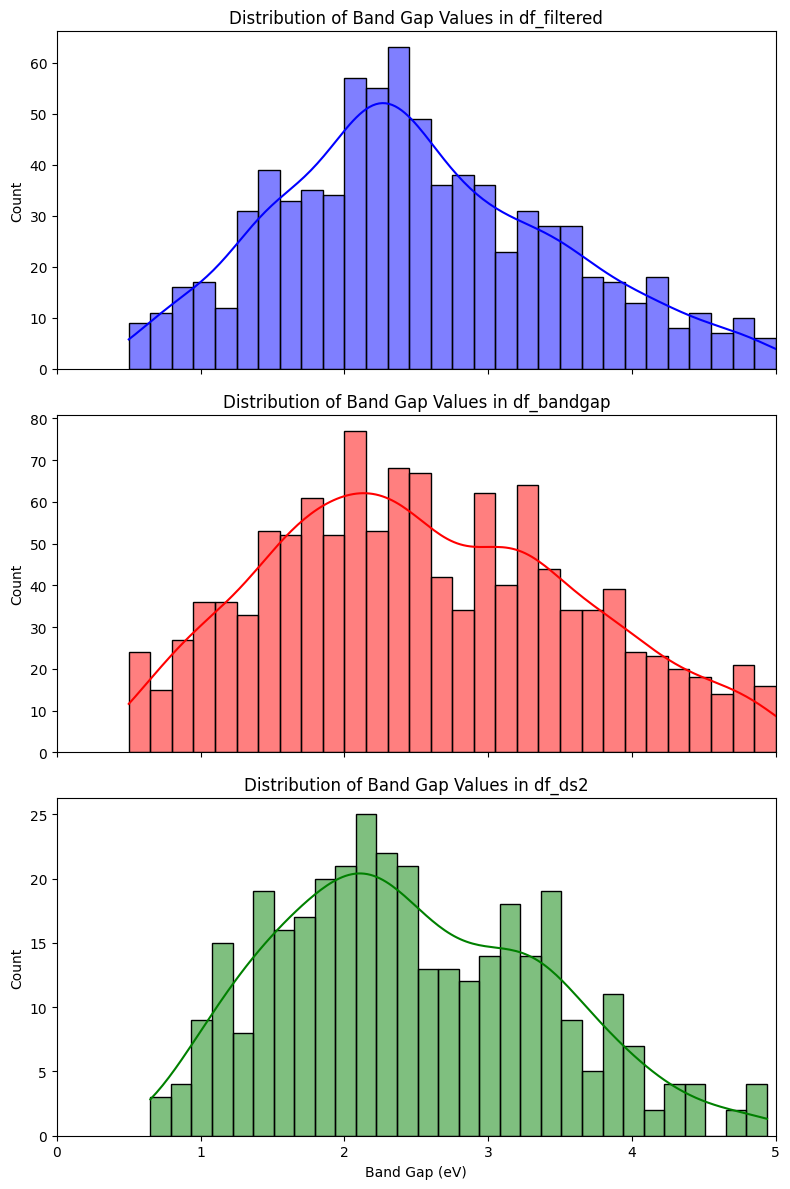

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set fixed x and y axis range
x_range = (0, 5)  # Band gap range from 0 to 5 eV
y_range = (0, None)  # Let y-axis adjust based on data density

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot distribution for df_filtered
sns.histplot(df_filtered["bg_expt"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Band Gap Values in df_filtered")
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)
axes[0].set_xlabel("Band Gap (eV)")

# Plot distribution for df_bandgap
sns.histplot(df_bandgap["Value"], bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Band Gap Values in df_bandgap")
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)
axes[1].set_xlabel("Band Gap (eV)")

# Plot distribution for df_ds2
sns.histplot(df_ds2["bg"], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribution of Band Gap Values in df_ds2")
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)
axes[2].set_xlabel("Band Gap (eV)")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



In [9]:
# Convert mpids columns to sets for easy comparison
mpids_filtered = set(df_filtered["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Find overlap sets
overlap_filtered_bandgap = mpids_filtered & mpids_bandgap
overlap_filtered_ds2 = mpids_filtered & mpids_ds2
overlap_bandgap_ds2 = mpids_bandgap & mpids_ds2
overlap_all_three = mpids_filtered & mpids_bandgap & mpids_ds2

# Merge DataFrames to keep band gap values from both sources
df_overlap_filtered_bandgap = df_filtered[df_filtered["mpids"].isin(overlap_filtered_bandgap)].merge(
    df_bandgap[["mpids", "Value"]], on="mpids", how="left", suffixes=("_filtered", "_bandgap")
)

df_overlap_filtered_ds2 = df_filtered[df_filtered["mpids"].isin(overlap_filtered_ds2)].merge(
    df_ds2[["mpids", "bg"]], on="mpids", how="left", suffixes=("_filtered", "_ds2")
)

df_overlap_bandgap_ds2 = df_bandgap[df_bandgap["mpids"].isin(overlap_bandgap_ds2)].merge(
    df_ds2[["mpids", "bg"]], on="mpids", how="left", suffixes=("_bandgap", "_ds2")
)

df_overlap_all_three = df_filtered[df_filtered["mpids"].isin(overlap_all_three)].merge(
    df_bandgap[["mpids", "Value"]], on="mpids", how="left", suffixes=("_filtered", "_bandgap")
).merge(
    df_ds2[["mpids", "bg"]], on="mpids", how="left", suffixes=("", "_ds2")
)

# Display the first few rows of each DataFrame
df_overlap_filtered_bandgap.head()


,formula,bg_expt,mpids,elements,is_stable,theoretical,band_gap,formation_energy_per_atom,Value
0,Ag8GeS6,1.18,mp-9770,"[Element Ag, Element Ge, Element S]",True,False,0.6102,-0.326872,1.45
1,AgBiS2,0.90,mp-29678,"[Element Ag, Element Bi, Element S]",False,False,0.5212,-0.289343,0.98
2,AgBr,2.52,mp-23231,"[Element Ag, Element Br]",True,False,0.7304,-0.659621,2.60
3,AgP15,1.47,mp-1195243,"[Element Ag, Element P]",False,False,1.2132,0.002923,1.38
4,AgPd(IO3)3,1.50,mp-1193499,"[Element Ag, Element I, Element O, Element Pd]",False,False,1.4039,-0.736863,1.50


In [10]:
# # Ensure df_unique_filtered and df_bandgap are available and contain the relevant band gap column
# plt.figure(figsize=(8, 6))

# # Plot distribution for df_unique_filtered
# sns.histplot(df_unique_filtered["bg_expt"], bins=30, kde=True, label="Unique in df_filtered", color="blue")

# # Plot distribution for df_bandgap
# sns.histplot(df_bandgap["Value"], bins=30, kde=True, label="df_bandgap", color="red")

# plt.title("Comparison of Band Gap Distributions: Unique in df_filtered vs. df_bandgap")
# plt.xlabel("Band Gap (eV)")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

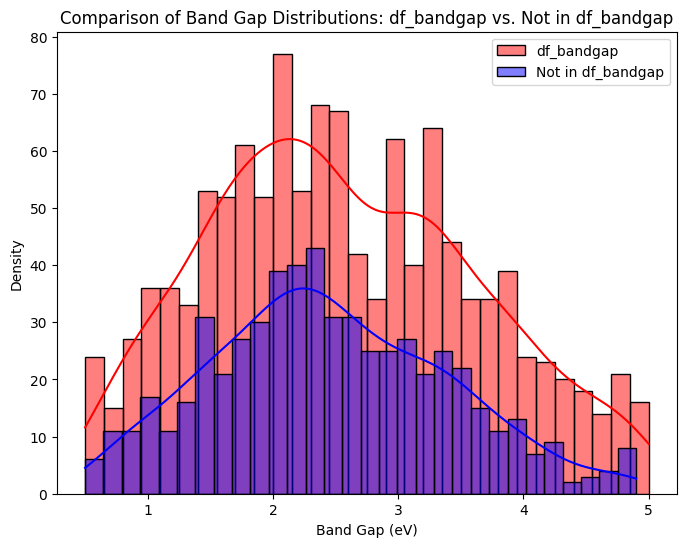

In [11]:

# Convert mpids columns to sets for easy comparison
mpids_bandgap = set(df_bandgap["mpids"])

# Find data that is NOT in df_bandgap (from df_filtered and df_ds2)
df_not_in_bandgap = pd.concat([df_filtered, df_ds2], ignore_index=True)
df_not_in_bandgap = df_not_in_bandgap[~df_not_in_bandgap["mpids"].isin(mpids_bandgap)]

# Plot distributions
plt.figure(figsize=(8, 6))

# Plot distribution for df_bandgap
sns.histplot(df_bandgap["Value"], bins=30, kde=True, label="df_bandgap", color="red")

# Plot distribution for data not in df_bandgap
sns.histplot(df_not_in_bandgap["bg_expt"].fillna(df_not_in_bandgap["bg"]), bins=30, kde=True, label="Not in df_bandgap", color="blue")

plt.title("Comparison of Band Gap Distributions: df_bandgap vs. Not in df_bandgap")
plt.xlabel("Band Gap (eV)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [12]:
df_ds2

,mpids,formula,bg_mp,bg
0,mp-390,TiO2,2.0625,3.20
1,mp-2657,TiO2,1.7719,3.02
2,mp-32777,WO3,1.2338,2.76
3,mp-619461,WO3,1.3712,2.73
6,mp-19009,NiO,2.4141,3.54
...,...,...,...,...
501,mp-2979,ZnGeN2,1.6966,3.36
502,mp-1392,ZnP2,0.7480,1.42
503,mp-560588,ZnS,2.0776,3.91
504,mp-13334,ZnSnO3,1.0810,3.90


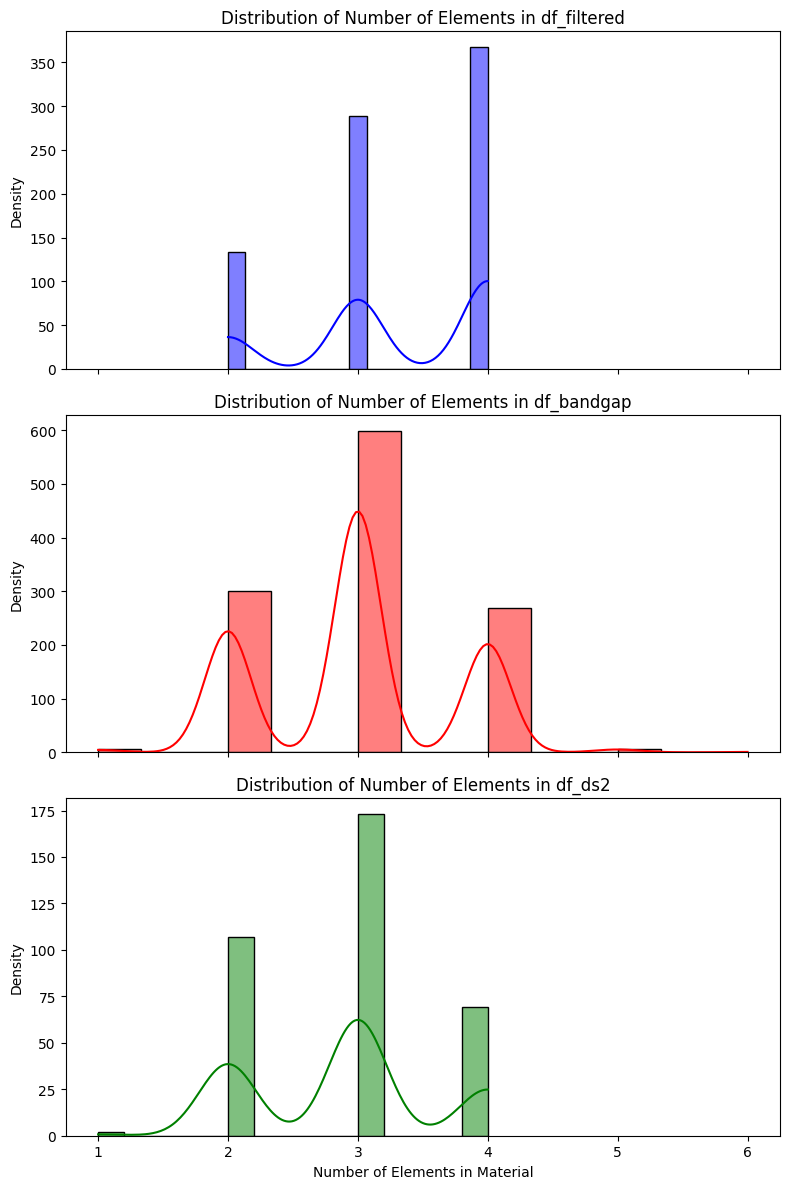

In [13]:

# Function to count the number of elements in the formula
def count_elements(formula):
    return sum(1 for char in formula if char.isupper())  # Count uppercase letters

# Apply the function to count elements for each dataset
df_filtered["num_elements"] = df_filtered["formula"].apply(count_elements)
df_bandgap["num_elements"] = df_bandgap["formula"].apply(count_elements)
df_ds2["num_elements"] = df_ds2["formula"].apply(count_elements)

# Create separate subplots for each dataset
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot distribution for df_filtered
sns.histplot(df_filtered["num_elements"], bins=15, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Number of Elements in df_filtered")
axes[0].set_ylabel("Density")

# Plot distribution for df_bandgap
sns.histplot(df_bandgap["num_elements"], bins=15, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Number of Elements in df_bandgap")
axes[1].set_ylabel("Density")

# Plot distribution for df_ds2
sns.histplot(df_ds2["num_elements"], bins=15, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribution of Number of Elements in df_ds2")
axes[2].set_xlabel("Number of Elements in Material")
axes[2].set_ylabel("Density")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [14]:


# Count the number of materials for each unique element count in each dataset
count_filtered = df_filtered["num_elements"].value_counts().sort_index()
count_bandgap = df_bandgap["num_elements"].value_counts().sort_index()
count_ds2 = df_ds2["num_elements"].value_counts().sort_index()

# Determine the maximum number of elements across all datasets
max_elements = max(count_filtered.index.max(), count_bandgap.index.max(), count_ds2.index.max())

# Create a complete index range for reindexing
element_range = range(1, max_elements + 1)

# Reindex the counts to ensure equal length and fill missing values with 0
count_filtered = count_filtered.reindex(element_range, fill_value=0)
count_bandgap = count_bandgap.reindex(element_range, fill_value=0)
count_ds2 = count_ds2.reindex(element_range, fill_value=0)

# Create a summary table with datasets as rows
summary_table = pd.DataFrame({
    "matbench_expt": count_filtered,
    "BandgapDatabase1": count_bandgap,
    "DS2": count_ds2
}).fillna(0).astype(int)

# Rename the index as "# of Elements"
summary_table.index.name = "# of Elements"


summary_table

,matbench_expt,BandgapDatabase1,DS2
# of Elements,,,
1,0,6,2
2,133,301,107
3,289,599,173
4,367,269,69
5,0,7,0
6,0,1,0


In [15]:
# Function to count the number of elements in a formula
def count_elements(formula):
    return sum(1 for char in formula if char.isupper()) if isinstance(formula, str) else None

# Ensure the num_elements column is calculated for unique datasets
if "formula" in df_unique_filtered.columns:
    df_unique_filtered["num_elements"] = df_unique_filtered["formula"].apply(count_elements)

if "formula" in df_unique_bandgap.columns:
    df_unique_bandgap["num_elements"] = df_unique_bandgap["formula"].apply(count_elements)

if "formula" in df_unique_ds2.columns:
    df_unique_ds2["num_elements"] = df_unique_ds2["formula"].apply(count_elements)

# Count the number of materials for each unique element count in each dataset
count_unique_filtered = df_unique_filtered["num_elements"].value_counts().sort_index()
count_unique_bandgap = df_unique_bandgap["num_elements"].value_counts().sort_index()
count_unique_ds2 = df_unique_ds2["num_elements"].value_counts().sort_index()

# Determine the maximum number of elements across all datasets
max_elements_unique = max(count_unique_filtered.index.max(), count_unique_bandgap.index.max(), count_unique_ds2.index.max())

# Create a complete index range for reindexing
element_range_unique = range(1, max_elements_unique + 1)

# Reindex the counts to ensure equal length and fill missing values with 0
count_unique_filtered = count_unique_filtered.reindex(element_range_unique, fill_value=0)
count_unique_bandgap = count_unique_bandgap.reindex(element_range_unique, fill_value=0)
count_unique_ds2 = count_unique_ds2.reindex(element_range_unique, fill_value=0)

# Create a summary table with datasets as rows
summary_table_unique = pd.DataFrame({
    "unique_matbench": count_unique_filtered,
    "unique_bandgapdatabase1": count_unique_bandgap,
    "unique_ds2": count_unique_ds2
}).fillna(0).astype(int)

summary_table_unique

NameError: name 'df_unique_filtered' is not defined

In [ ]:
# Ensure necessary libraries are imported
import pandas as pd

# Merge dataframes on 'mpids' to compare their values
df_merged = df_filtered.merge(df_bandgap, on="mpids", how="inner", suffixes=("_filtered", "_bandgap"))
df_merged = df_merged.merge(df_ds2, on="mpids", how="inner")

# Rename columns for clarity
df_merged.rename(columns={"bg_expt": "df_filtered_bg_expt", 
                          "Value": "df_bandgap_Value", 
                          "bg": "df_ds2_bg"}, inplace=True)

# Calculate differences
df_merged["filtered_vs_bandgap"] = df_merged["df_filtered_bg_expt"] - df_merged["df_bandgap_Value"]
df_merged["filtered_vs_ds2"] = df_merged["df_filtered_bg_expt"] - df_merged["df_ds2_bg"]
df_merged["bandgap_vs_ds2"] = df_merged["df_bandgap_Value"] - df_merged["df_ds2_bg"]

df_merged


,formula_filtered,df_filtered_bg_expt,mpids,elements,is_stable_filtered,theoretical_filtered,band_gap_filtered,formation_energy_per_atom_filtered,num_elements_filtered,formula_bandgap,...,DOI,compound_type,num_elements_bandgap,formula,bg_mp,df_ds2_bg,num_elements,filtered_vs_bandgap,filtered_vs_ds2,bandgap_vs_ds2
0,AgBr,2.52,mp-23231,"[Element Ag, Element Br]",True,False,0.7304,-0.659621,2,AgBr,...,10.1016/j.cej.2013.03.091,Halides,2,AgBr,0.7946,2.7125,2,-0.08,-0.1925,-0.1125
1,Al2Se3,3.10,mp-11674,"[Element Al, Element Se]",True,False,1.8004,-1.008824,2,Al2Se3,...,10.1039/c7tc05311h,Double anions,2,Al2Se3,2.1576,3.1000,2,0.00,0.0000,0.0000
2,B6P,3.30,mp-28395,"[Element B, Element P]",True,False,2.4757,-0.326224,2,B6P,...,10.1103/PhysRevB.60.2333,Phosphides,2,B12P2,2.7253,3.3500,2,0.00,-0.0500,-0.0500
3,Ba3MgTa2O9,4.28,mp-6325,"[Element Ba, Element Mg, Element O, Element Ta]",True,False,3.2733,-3.413044,4,Ba3MgTa2O9,...,10.1016/j.jssc.2007.12.007,Double anions,4,Ba3MgTa2O9,3.2747,4.2800,4,0.00,0.0000,0.0000
4,BaCuTeF,2.30,mp-13287,"[Element Ba, Element Cu, Element F, Element Te]",False,False,0.9884,-2.131592,4,BaCuTeF,...,10.1016/j.tsf.2007.10.073,Halides,4,BaCuTeF,0.9884,2.3000,4,-0.35,0.0000,0.3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,TlGaTe2,1.80,mp-3785,"[Element Ga, Element Te, Element Tl]",True,False,0.5556,-0.578234,3,TlGaTe2,...,10.1039/c8tc03492c,Double anions,3,TlGaTe2,0.5814,1.2000,3,0.85,0.6000,-0.2500
85,TlInTe2,0.62,mp-22791,"[Element In, Element Te, Element Tl]",True,False,0.5401,-0.570601,3,TlInTe2,...,10.1039/c8tc03492c,Double anions,3,TlInTe2,0.6499,0.9630,3,-0.24,-0.3430,-0.1030
86,ZnSiP2,2.07,mp-4763,"[Element P, Element Si, Element Zn]",True,False,1.3641,-0.391657,3,ZnSiP2,...,10.1039/c5ee02884a,Double anions,3,ZnSiP2,1.3641,2.3000,3,-0.03,-0.2300,-0.2000
87,ZnSnO3,3.90,mp-13334,"[Element O, Element Sn, Element Zn]",False,False,1.0810,-1.939425,3,ZnSnO3,...,10.1016/j.optmat.2017.05.056,Chalcogenides,3,ZnSnO3,1.0810,3.9000,3,0.85,0.0000,-0.8500


In [ ]:
# # Re-import necessary libraries since execution state was reset
# import pandas as pd

# # Assuming df_filtered, df_bandgap, and df_ds2 have been reloaded

# # Merge dataframes on 'mpids' to compare their values
# df_merged = df_filtered.merge(df_bandgap, on="mpids", how="inner", suffixes=("_filtered", "_bandgap"))
# df_merged = df_merged.merge(df_ds2, on="mpids", how="inner")

# # Rename columns for clarity
# df_merged.rename(columns={"bg_expt": "bg_filtered", 
#                           "Value": "bg_bandgap", 
#                           "bg": "bg_ds2"}, inplace=True)

# # Calculate differences
# df_merged["filtered_vs_bandgap"] = df_merged["bg_filtered"] - df_merged["bg_bandgap"]
# df_merged["filtered_vs_ds2"] = df_merged["bg_filtered"] - df_merged["bg_ds2"]
# df_merged["bandgap_vs_ds2"] = df_merged["bg_bandgap"] - df_merged["bg_ds2"]

# # Keep only necessary columns: mpids, formula, bg values, and differences
# df_tidy = df_merged[["mpids", "formula", "bg_filtered", "bg_bandgap", "bg_ds2", 
#                      "filtered_vs_bandgap", "filtered_vs_ds2", "bandgap_vs_ds2"]]

# df_tidy


In [ ]:
# scatter plot, heatmap, and histogram for band gap differences. but only for the materials in all three datasets

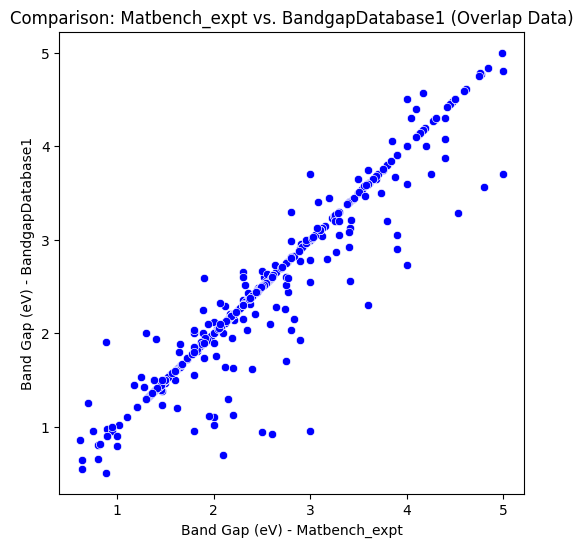

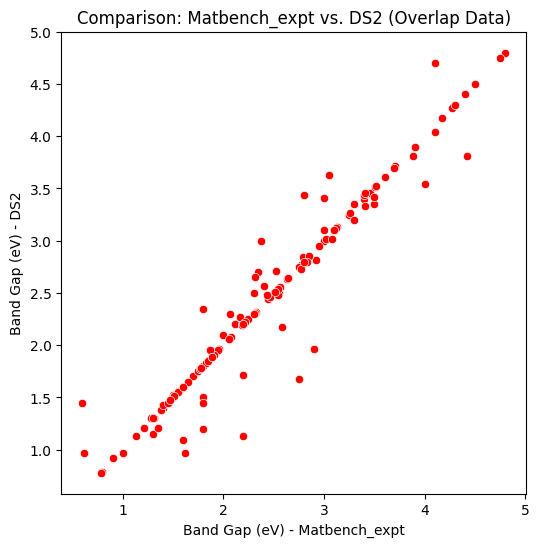

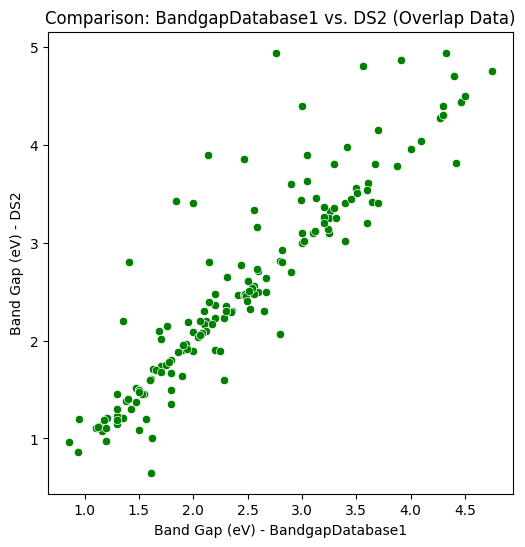

In [ ]:
# Scatter Plot: Matbench_expt vs. BandgapDatabase1
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_overlap_filtered_bandgap["bg_expt"], y=df_overlap_filtered_bandgap["Value"], color="blue")
plt.title("Comparison: Matbench_expt vs. BandgapDatabase1 (Overlap Data)")
plt.xlabel("Band Gap (eV) - Matbench_expt")
plt.ylabel("Band Gap (eV) - BandgapDatabase1")
plt.show()

# Scatter Plot: Matbench_expt vs. DS2
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_overlap_filtered_ds2["bg_expt"], y=df_overlap_filtered_ds2["bg"], color="red")
plt.title("Comparison: Matbench_expt vs. DS2 (Overlap Data)")
plt.xlabel("Band Gap (eV) - Matbench_expt")
plt.ylabel("Band Gap (eV) - DS2")
plt.show()

# Scatter Plot: BandgapDatabase1 vs. DS2
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_overlap_bandgap_ds2["Value"], y=df_overlap_bandgap_ds2["bg"], color="green")
plt.title("Comparison: BandgapDatabase1 vs. DS2 (Overlap Data)")
plt.xlabel("Band Gap (eV) - BandgapDatabase1")
plt.ylabel("Band Gap (eV) - DS2")
plt.show()

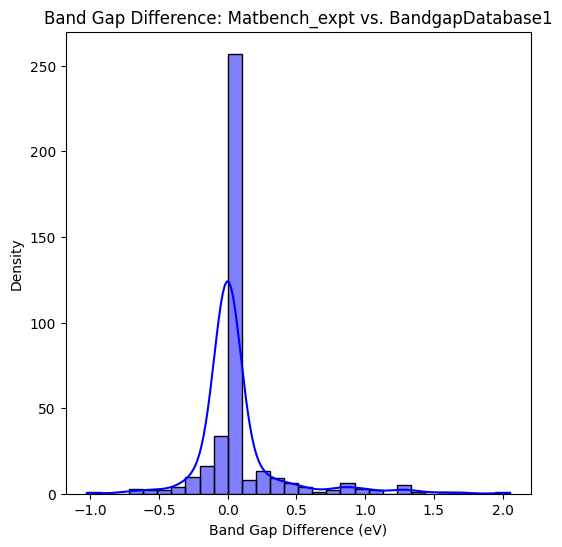

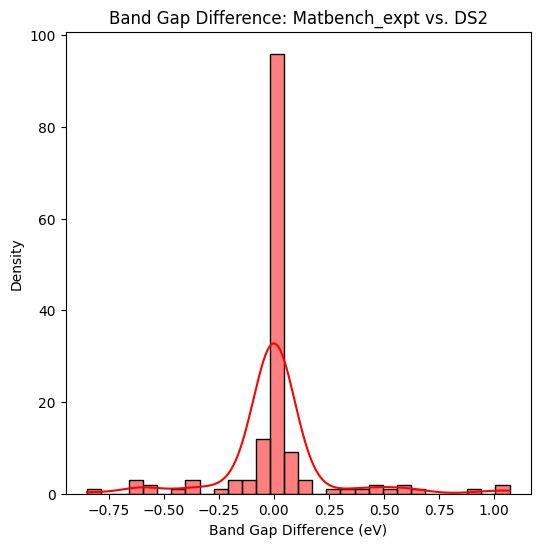

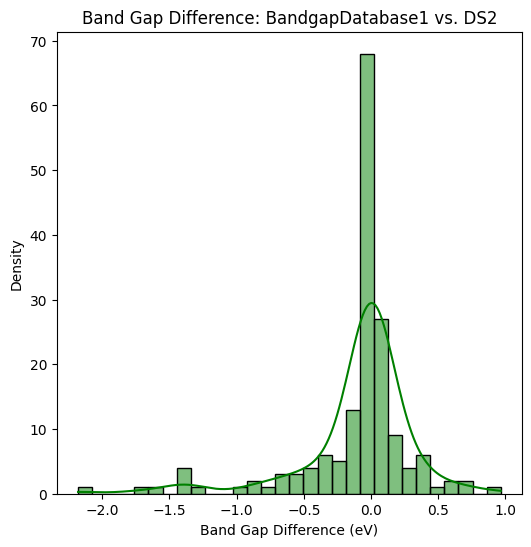

In [ ]:
# band gap difference for each dataset

# Compute band gap differences
df_overlap_filtered_bandgap["diff"] = df_overlap_filtered_bandgap["bg_expt"] - df_overlap_filtered_bandgap["Value"]
df_overlap_filtered_ds2["diff"] = df_overlap_filtered_ds2["bg_expt"] - df_overlap_filtered_ds2["bg"]
df_overlap_bandgap_ds2["diff"] = df_overlap_bandgap_ds2["Value"] - df_overlap_bandgap_ds2["bg"]

# Plot band gap differences: Matbench_expt vs. BandgapDatabase1
plt.figure(figsize=(6, 6))
sns.histplot(df_overlap_filtered_bandgap["diff"], bins=30, kde=True, color="blue")
plt.title("Band Gap Difference: Matbench_expt vs. BandgapDatabase1")
plt.xlabel("Band Gap Difference (eV)")
plt.ylabel("Density")
plt.show()

# Plot band gap differences: Matbench_expt vs. DS2
plt.figure(figsize=(6, 6))
sns.histplot(df_overlap_filtered_ds2["diff"], bins=30, kde=True, color="red")
plt.title("Band Gap Difference: Matbench_expt vs. DS2")
plt.xlabel("Band Gap Difference (eV)")
plt.ylabel("Density")
plt.show()

# Plot band gap differences: BandgapDatabase1 vs. DS2
plt.figure(figsize=(6, 6))
sns.histplot(df_overlap_bandgap_ds2["diff"], bins=30, kde=True, color="green")
plt.title("Band Gap Difference: BandgapDatabase1 vs. DS2")
plt.xlabel("Band Gap Difference (eV)")
plt.ylabel("Density")
plt.show()

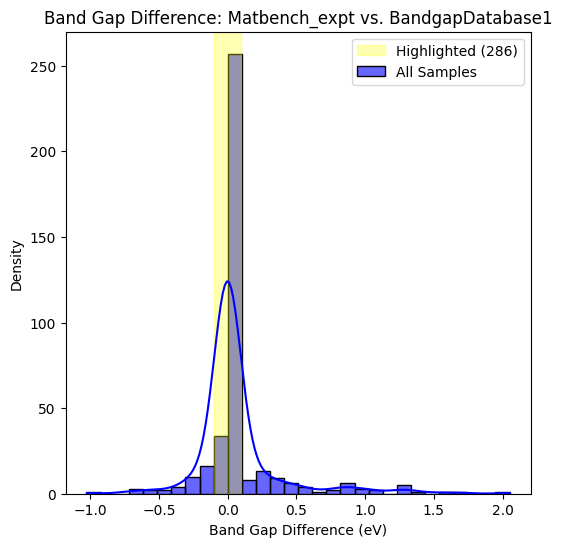

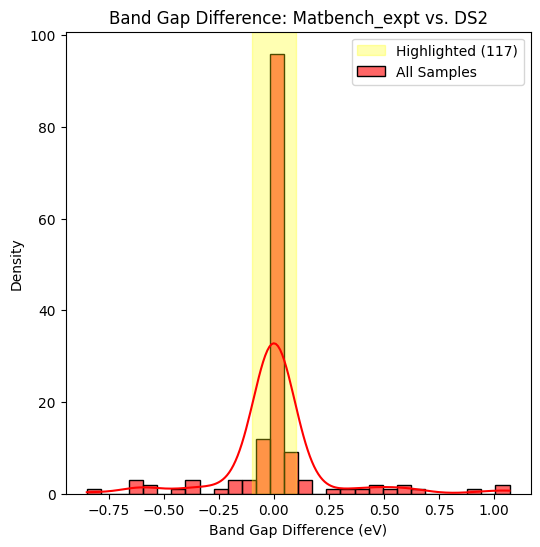

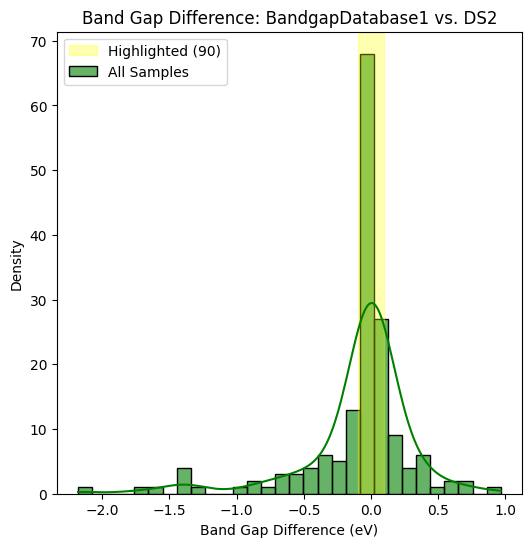

In [ ]:
# plot of the band gap differences for datasets overlap, the highlighted samples are those with difference in range [-0.1, 0.1]

# Compute band gap differences
df_overlap_filtered_bandgap["diff"] = df_overlap_filtered_bandgap["bg_expt"] - df_overlap_filtered_bandgap["Value"]
df_overlap_filtered_ds2["diff"] = df_overlap_filtered_ds2["bg_expt"] - df_overlap_filtered_ds2["bg"]
df_overlap_bandgap_ds2["diff"] = df_overlap_bandgap_ds2["Value"] - df_overlap_bandgap_ds2["bg"]

# Filter samples with difference in range [-0.1, 0.1]
df_close_filtered_bandgap = df_overlap_filtered_bandgap[df_overlap_filtered_bandgap["diff"].between(-0.1, 0.1)]
df_close_filtered_ds2 = df_overlap_filtered_ds2[df_overlap_filtered_ds2["diff"].between(-0.1, 0.1)]
df_close_bandgap_ds2 = df_overlap_bandgap_ds2[df_overlap_bandgap_ds2["diff"].between(-0.1, 0.1)]

# Function to plot histogram and highlight samples with count label
def plot_difference(df, df_close, title, color):
    plt.figure(figsize=(6, 6))
    sns.histplot(df["diff"], bins=30, kde=True, color=color, alpha=0.6, label="All Samples")
    plt.axvspan(-0.1, 0.1, color="yellow", alpha=0.3, label=f"Highlighted ({len(df_close)})")
    plt.title(title)
    plt.xlabel("Band Gap Difference (eV)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot differences with highlights and labels
plot_difference(df_overlap_filtered_bandgap, df_close_filtered_bandgap, "Band Gap Difference: Matbench_expt vs. BandgapDatabase1", "blue")
plot_difference(df_overlap_filtered_ds2, df_close_filtered_ds2, "Band Gap Difference: Matbench_expt vs. DS2", "red")
plot_difference(df_overlap_bandgap_ds2, df_close_bandgap_ds2, "Band Gap Difference: BandgapDatabase1 vs. DS2", "green")


In [ ]:
df_close_bandgap_ds2

,formula,mpids,is_stable,theoretical,band_gap,formation_energy_per_atom,Value,DOI,compound_type,bg,diff
0,Ag2MoO4,mp-19318,False,False,1.8731,-1.251053,3.260,10.1016/j.physb.2019.02.036,Double anions,3.32,-0.060
3,Al2Se3,mp-11674,True,False,1.8004,-1.008824,3.100,10.1039/c7tc05311h,Double anions,3.10,0.000
4,AlAs,mp-2172,True,False,1.5037,-0.627043,2.200,10.1016/j.matpr.2017.11.028,Arsenides,2.23,-0.030
6,AsI3,mp-23218,True,False,2.2375,-0.478643,2.415,10.1021/jacs.5b03986,Halides,2.47,-0.055
7,B6P,mp-28395,True,False,2.4757,-0.326224,3.300,10.1103/PhysRevB.60.2333,Phosphides,3.35,-0.050
...,...,...,...,...,...,...,...,...,...,...,...
150,Tl2TeI6,mp-31077,True,False,1.6844,-0.641614,1.500,10.1039/c9nj03660a,Double anions,1.47,0.030
151,Tl2TeS3,mp-17172,False,False,1.2603,-0.458696,1.600,10.1016/j.jssc.2007.10.005,Double anions,1.60,0.000
152,Tl3AsSe3,mp-7684,True,False,0.8814,-0.512025,1.300,10.1039/C2JM33029F,Chalcogenides,1.30,0.000
153,Tl4CdI6,mp-570339,False,False,2.1721,-0.841667,2.815,10.1016/j.matchemphys.2015.08.014,Halides,2.80,0.015


In [54]:
# Ensure necessary libraries are imported
import pandas as pd

# Reload data and define MPIDs based on the Venn diagram
mpids_filtered = set(df_filtered["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Find overlap sets
overlap_filtered_bandgap = mpids_filtered & mpids_bandgap
overlap_filtered_ds2 = mpids_filtered & mpids_ds2
overlap_bandgap_ds2 = mpids_bandgap & mpids_ds2
overlap_all_three = mpids_filtered & mpids_bandgap & mpids_ds2  # MPIDs present in all three datasets

# Remove MPIDs that are in all three from individual overlap sets
overlap_filtered_bandgap -= overlap_all_three
overlap_filtered_ds2 -= overlap_all_three
overlap_bandgap_ds2 -= overlap_all_three

# Create new DataFrames ensuring bg_exp always comes from df_bandgap
df_overlap_filtered_bandgap = df_bandgap[df_bandgap["mpids"].isin(overlap_filtered_bandgap)][["mpids", "bg_mp", "bg_exp"]]
df_overlap_filtered_ds2 = df_filtered[df_filtered["mpids"].isin(overlap_filtered_ds2)][["mpids", "bg_mp", "bg_exp"]]
df_overlap_bandgap_ds2 = df_bandgap[df_bandgap["mpids"].isin(overlap_bandgap_ds2)][["mpids", "bg_mp", "bg_exp"]]
df_overlap_all_three = df_bandgap[df_bandgap["mpids"].isin(overlap_all_three)][["mpids", "bg_mp", "bg_exp"]]  # Assigning bandgap from df_bandgap

# Add source column
df_overlap_filtered_bandgap["source"] = "BandgapDatabase1"
df_overlap_filtered_ds2["source"] = "Matbench_expt"
df_overlap_bandgap_ds2["source"] = "BandgapDatabase1"
df_overlap_all_three["source"] = "BandgapDatabase1"  # Assign a single source for consistency

# Concatenate overlap data (ensuring three-way overlaps appear only once)
df_combined_overlap = pd.concat([
    df_overlap_filtered_bandgap,
    df_overlap_filtered_ds2,
    df_overlap_bandgap_ds2,
    df_overlap_all_three
], ignore_index=True)

# Merge with unique data
df_combined = pd.concat([df_combined_overlap, df_unique_filtered, df_unique_bandgap, df_unique_ds2], ignore_index=True)

# Debugging: Check why NaN values exist
nan_rows = df_combined[df_combined["bg_exp"].isna()]
if not nan_rows.empty:
    missing_mpids = nan_rows["mpids"]
    df_bandgap_missing = df_bandgap[df_bandgap["mpids"].isin(missing_mpids)]

df_combined

,mpids,bg_mp,bg_exp,source
0,mp-9770,0.6102,1.450,BandgapDatabase1
1,mp-29678,0.5212,0.980,BandgapDatabase1
2,mp-1195243,1.2132,1.380,BandgapDatabase1
3,mp-1193499,1.4039,1.500,BandgapDatabase1
4,mp-1582,4.0339,4.500,BandgapDatabase1
...,...,...,...,...
1700,mp-22858,2.3198,2.867,DS2
1701,mp-558747,1.1772,1.300,DS2
1702,mp-4842,2.6027,3.500,DS2
1703,mp-1392,0.7480,1.420,DS2


In [55]:
df_combined["source"].value_counts()

source
BandgapDatabase1    1183
Matbench_expt        397
DS2                  125
Name: count, dtype: int64

In [56]:
# split the data into training and holdout sets
# Ensure data is loaded before processing
if "df_combined" in locals():
    # Split the dataset
    df_holdout = df_combined[df_combined["source"] == "Matbench_expt"]
    df_train = df_combined[df_combined["source"] != "Matbench_expt"]

else:
    print("Dataset not found. Please reload df_combined.")


In [58]:
df_train

,mpids,bg_mp,bg_exp,source
0,mp-9770,0.6102,1.450,BandgapDatabase1
1,mp-29678,0.5212,0.980,BandgapDatabase1
2,mp-1195243,1.2132,1.380,BandgapDatabase1
3,mp-1193499,1.4039,1.500,BandgapDatabase1
4,mp-1582,4.0339,4.500,BandgapDatabase1
...,...,...,...,...
1700,mp-22858,2.3198,2.867,DS2
1701,mp-558747,1.1772,1.300,DS2
1702,mp-4842,2.6027,3.500,DS2
1703,mp-1392,0.7480,1.420,DS2


In [62]:
# Ensure data is loaded before processing
if "df_train" in locals() and "df_holdout" in locals():
    # Convert df_train to JSON format including source
    df_train_json = df_train.set_index("mpids")[[ "bg_mp", "bg_exp", "source"]].to_dict(orient="index")

    # Convert df_holdout to JSON format including source
    df_holdout_json = df_holdout.set_index("mpids")[[ "bg_mp", "bg_exp", "source"]].to_dict(orient="index")

    # Save JSON files
    import json

    train_json_path = "./data/joint_dataset/train_data.json"
    holdout_json_path = "./data/joint_dataset/test_data.json"

    # create the directory
    import os
    os.makedirs(os.path.dirname(train_json_path), exist_ok=True)
    os.makedirs(os.path.dirname(holdout_json_path), exist_ok=True)

    with open(train_json_path, "w") as f:
        json.dump(df_train_json, f, indent=2)

    with open(holdout_json_path, "w") as f:
        json.dump(df_holdout_json, f, indent=2)

    # Provide download links
    train_json_path, holdout_json_path
else:
    print("Datasets not found. Please reload df_train and df_holdout.")
